<a href="https://colab.research.google.com/github/jlgao2/FYP-Sandbox/blob/master/Copy_of_lesson7_superres_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pretrained GAN

In [1]:
!curl https://course.fast.ai/setup/colab | bash
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0    419      0 --:--:-- --:--:-- --:--:--   419
Updating fastai...
Done.
Mounted at /content/gdrive


In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
#import re
#import pathlib2 as path2

In [0]:
# path = untar_data(URLs.PETS)
# path_hr = path/'images'
# path_lr = path/'crappy'
path = Path(base_dir + 'h5/')
path_hr = path/'train_img'
path_lr = path/'lr'


In [20]:
path_lr

PosixPath('/content/gdrive/My Drive/fastai-v3/data/h5/lr')

## Crappified data

Prepare the input data by crappifying images.

In [0]:
from crappify import *

In [0]:
import re
import math

#Replace the first two occurrences of a white-space character with the digit 9:

# txt = "b'8580800_5541200'n"
# x = re.sub("\s", "9", txt, 2)
# print(x)


# y = re.findall("[0-9]", x,)
# print(''.join(y))

In [0]:
shutil.rmtree(path_lr)

In [10]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr, path_hr), il.items)

For gradual resizing we can change the commented line here.

In [0]:
#bs,size=1, 400
bs,size = 16,160
#bs,size = 2,256
arch = models.resnet34

## Pre-train generator

Now let's pretrain the generator.

In [0]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data_gen = get_data(bs,size)

In [15]:
data_gen.show_batch(4)

In [0]:
wd = 1e-3

In [0]:
y_range = (-3.,3.)

In [0]:
loss_gen = MSELossFlat()

In [0]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [0]:
learn_gen = create_gen_learner()

In [21]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [0]:
learn_gen.unfreeze()

In [23]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

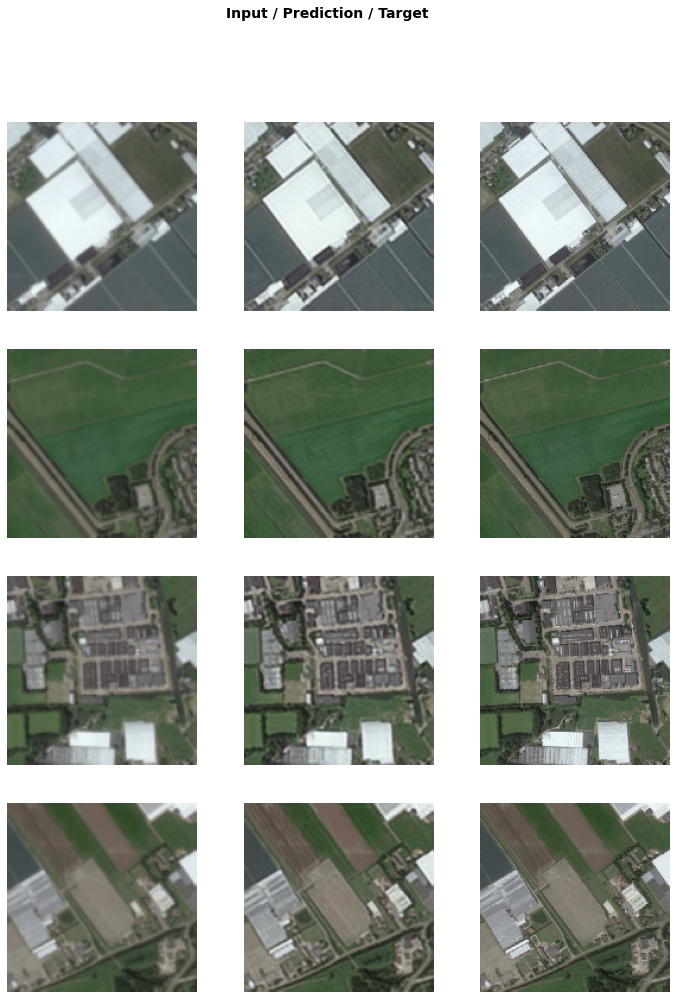

In [24]:
learn_gen.show_results(rows=4)

In [0]:
learn_gen.save ('gen-pre2')
# learn_gen.export('gen-pre2')

## Save generated images

In [26]:
learn_gen.load('gen-pre2')

Learner(data=ImageDataBunch;

Train: LabelList (360 items)
x: ImageImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
Path: /content/gdrive/My Drive/fastai-v3/h5/lr;

Valid: LabelList (40 items)
x: ImageImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
Path: /content/gdrive/My Drive/fastai-v3/h5/lr;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1,

In [0]:
from io import *

name_gen = 'image_gen'
path_gen = path/name_gen



In [0]:
#shutil.rmtree(path_gen)

In [0]:
path_gen.mkdir(exist_ok=True)

In [0]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1



In [0]:
save_preds(data_gen.fix_dl)

In [0]:
curpath = os.path.abspath(os.curdir)
print ("Current path is: %s" % (curpath))
print ("Trying to open: %s" % (os.path.join(curpath, path_gen)))

Current path is: C:\Users\georg\.fyp
Trying to open: C:\Users\georg\.fyp\data\h5\image_gen


In [0]:
#!conda list

In [31]:

PIL.Image.open(path_gen/'1.png')

## Train critic

In [32]:
learn_gen=None
gc.collect()

7

Pretrain the critic on crappy vs not crappy.

In [0]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [0]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

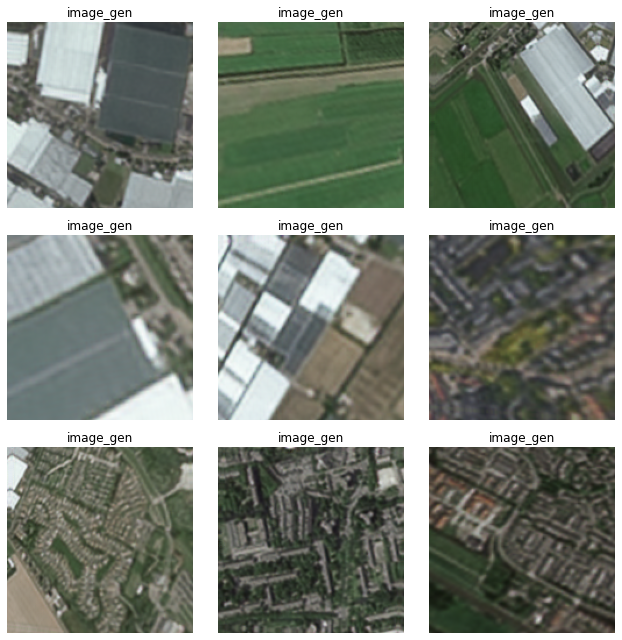

In [35]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [0]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [0]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [0]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [39]:
learn_critic.fit_one_cycle(6, 1e-3)

In [0]:
learn_critic.save('critic-pre2')

## GAN

Now we'll combine those pretrained model in a GAN.

In [53]:
learn_crit=None
learn_gen=None
gc.collect()

47775

In [42]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:454: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:457: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


IndexError: ignored

In [0]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [0]:
torch.cuda.empty_cache()

In [58]:
learn_gen = create_gen_learner().load('gen-pre2')

RuntimeError: ignored

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [0]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=True, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [0]:
lr = 1e-4

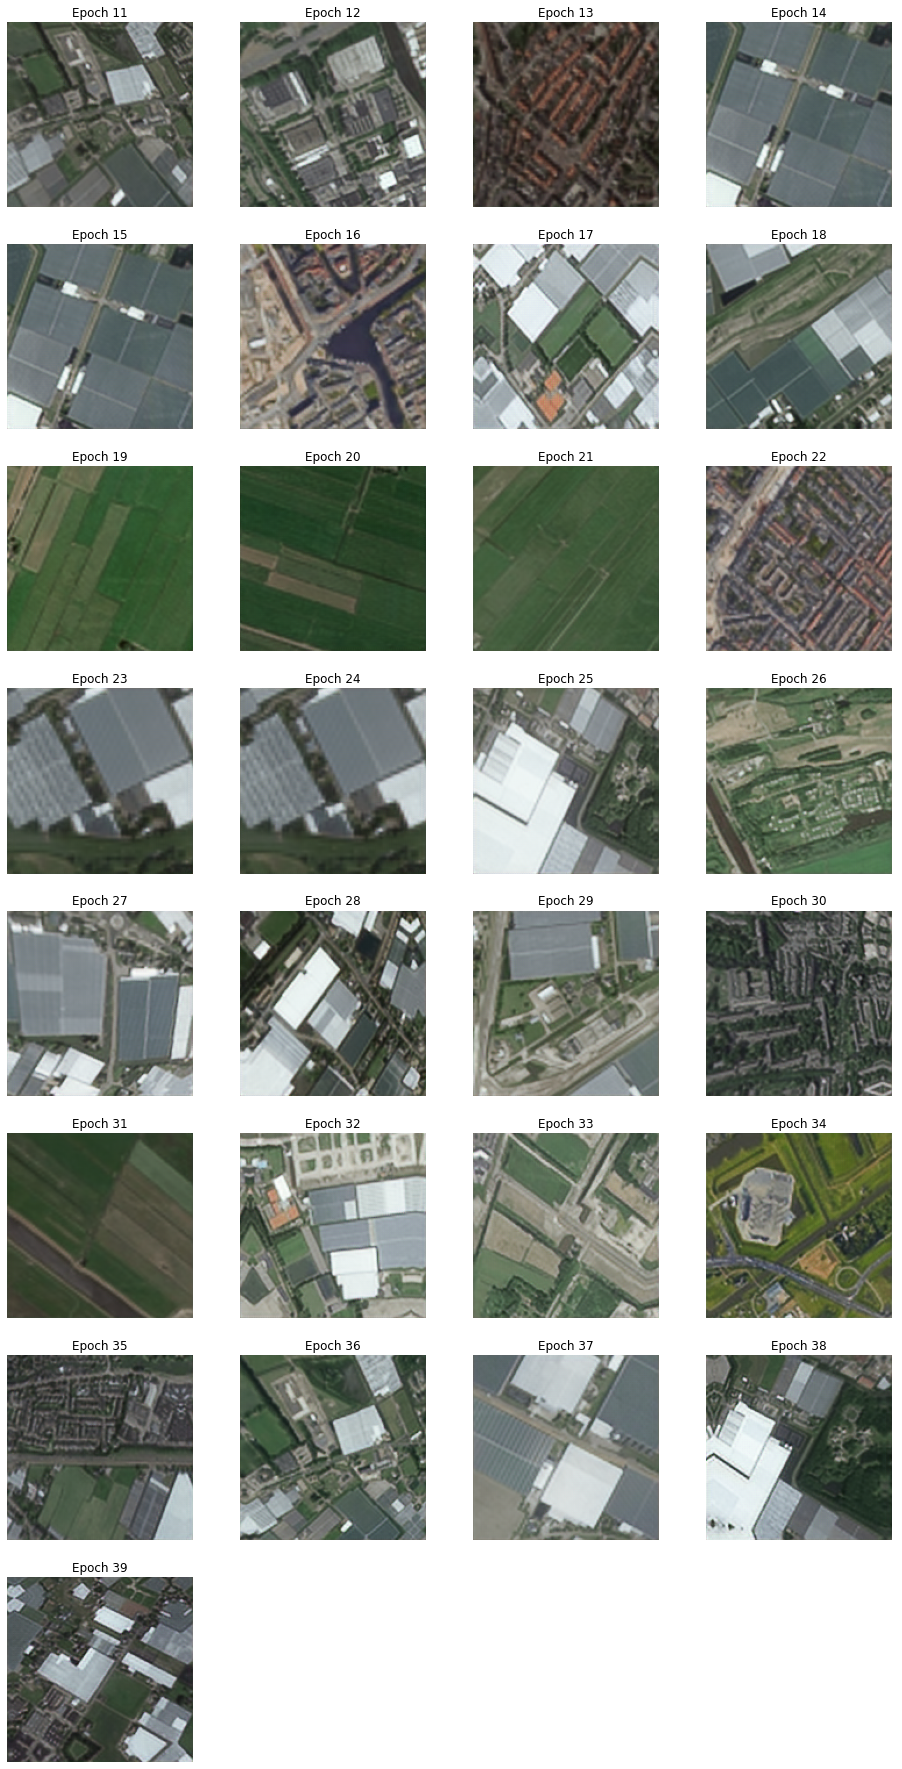

In [48]:
learn.fit(40,lr)

In [49]:
learn.show_results(rows=16)

In [0]:
learn.save('gan-1c')

In [0]:
learn.data=get_data(16,192)

In [54]:
learn.fit(10,lr/2)

RuntimeError: ignored

In [56]:
learn.show_results(rows=4)

RuntimeError: ignored

In [0]:
def save_gan_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [57]:
save_preds(data_gen.fix_dl)

AttributeError: ignored

## fin